### The Breakdown

After cleaning the dataset, the next step is to engineer features that can help our predictive models. Feature engineering is the practice of creating new features from existing ones. The engineered features are often more specific or isolate key information. Often, feature engineering is one of the most valuable tasks a data scientist can do to improve model effectiveness.

In this module, part 3 of 4 we'll load our cleaned dataset and then cover these steps: 

1. [Start with domain knowledge](#domain)
2. [Create interaction features](#interaction)
3. [Group sparse classes](#group)
4. [Encode dummy variables](#dummy)
5. [Remove unused or redundant features](#remove)

Finally, we'll save the augmented dataframe (analytical base table) to a new file so we can use it for modeling.

<br><hr>

### First, let's import libraries and load the cleaned dataset.

In general, it's good practice to keep all library imports at the top of the notebook. Then I'll import the **cleaned** dataset created in the previous module. For reference I'm going to display the head of the dataset so we can have all the existing features in front of us.

In [1]:
# Computing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.mode.chained_assignment = None  # default='warn'

# Visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 

In [2]:
# Load cleaned dataset from Module 2
df = pd.read_csv('/Users/brandonlewis/Desktop/jupyter-blog/content/Project Files/Real Estate Price Forecasting/cleaned_df.csv')

df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,Missing,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,Missing,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


<br id="domain">
### 1. Start with domain knowledge

You can often engineer informative features by tapping into your (or others') expertise about the domain. I know that 2 bed/2 bath properties are especially popular. I also know the housing market was hit hard during the recession between 2010 and 2013. So I'm going to create indicator variables for both situations. I'll use boolean masks to create both features. I also make sure to append the <code style="color:steelblue">.astype(int)</code> method to my code so that my feature maps to <code style="color:crimson">1/0</code> and not <code style="color:crimson">True/False</code>.

In [3]:
# Create indicator variable for properties with 2 beds and 2 baths
df['two_and_two'] = ((df['beds']==2) & (df['baths']==2)).astype(int)

# Display percent of rows where two_and_two == 1
df.two_and_two.mean()

0.09458023379383634

In [4]:
# Create indicator feature for transactions between 2010 and 2013, inclusive
df['during_recession'] = ((df.tx_year >= 2010) & (df.tx_year <= 2013)).astype(int)

# Print percent of transactions where during_recession == 1
df.during_recession.mean()

0.2635494155154091

In the case where we're checking to see if a value falls between two numbers, there's a shortcut:

<pre style="color:steelblue">df.tx_year<strong>.between(2010, 2013)</strong>.astype(int)</pre>

This creates an indicator feature that should be equivalent to the one we just created from combining two boolean masks.

In [5]:
# Set variable a as the earlier indicator variable (combining two masks)
a = df.during_recession

# Set variable b as the new indicator variable (using "between")
b = df.tx_year.between(2010,2013).astype(int)

# Are a and b equivalent?
all(a==b)

True

In [6]:
# Create indicator feature for transactions between 2010 and 2013, inclusive
df.during_recession = b

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">
<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="interaction">
### 2. Create interaction features

Interaction features are built from the aritmetic interaction of existing features. Not every interaction feature is a strong predictor of the target variable but one standout feature makes up for 10 duds. The key is choosing machine learning algorithms that can effectively select the best features among many options (**built-in feature selection**). This will allow you to avoid overfitting your model despite providing many input features. So here we use our creativity to come up with what we think may be useful interaction features. I think that having a propety age feature and a school score are likely to be helpful in predicting transaction price.

To create <code style="color:steelblue">'property_age'</code> I subtract <code style="color:steelblue">'year_built'</code> from <code style="color:steelblue">'tx_year'</code> and find that there are several properties with a negative property age. This indicates probably a transcription error so we drop these observations. 

In [7]:
# Create a property age feature
df['property_age'] = df.tx_year - df.year_built

# Should not be less than 0
df.property_age.min()

-8

In [8]:
# Number of observations with 'property_age' < 0
print(sum(df.property_age < 0))

19


In [9]:
# Remove rows where property_age is less than 0
df = df[df.property_age > 0]

# Print number of rows in remaining dataframe
print(len(df))

1617


Now, let's add another interaction feature. How about the number of quality schools nearby?

* Well, we do know the number of schools nearby (<code style="color:steelblue">'num_schools'</code>) 
* We also have their median quality score (<code style="color:steelblue">'median_schools'</code>)
* But what if it's the **interaction** of those two factors that's really important? 
* In other words, what if it's good to have many school options, but only if they are good?

In [10]:
# Create a school score feature that num_schools * median_school
df['school_score'] = df.num_schools * df.median_school

# Display median school score
df.school_score.median()

18.0

<hr style="border-color:royalblue;background-color:royalblue;height:1px;">
<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="group">
### 3. Group sparse classes

The next heuristic I'll consider is grouping sparse classes in our categorical features. I'll do this for both of the sparse class features we identified in the Exploratory Analysis: <code style="color:steelblue">'exterior_walls'</code> and <code style="color:steelblue">'roof'</code>.

I begin by plotting the bar plots for <code style="color:steelblue">'exterior_walls'</code> again. Here I see there are many categories that don't have much data. I'm going to group <code style="color:crimson">'Wood Siding'</code>, <code style="color:crimson">'Wood Shingle'</code>, and <code style="color:crimson">'Wood'</code> together. I'm going to label all of them as <code style="color:crimson">'Wood'</code>. For the remaining sparse classes we'll create an <code style="color:crimson">'other'</code> label.

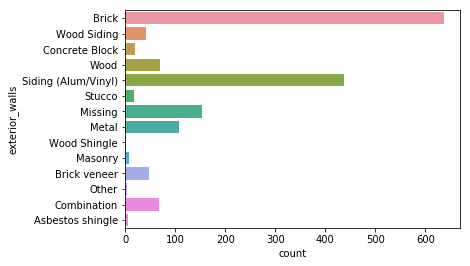

In [11]:
# Bar plot for exterior_walls
sns.countplot(y='exterior_walls', data=df)

In [12]:
# Group 'Wood Siding' and 'Wood Shingle' with 'Wood'
df.exterior_walls.replace(['Wood Siding', 'Wood Shingle', 'Wood'], 'Wood', inplace=True)

# List of classes to group
other_exterior_walls = ['Stucco', 'Other', 'Asbestos shingle', 'Concrete Block', 'Masonry']

# Group other classes into 'Other'
df.exterior_walls.replace(other_exterior_walls, 'Other', inplace=True)

Finally, now that the sparse classes have been grouped together, let's look at the bar plot for exterior walls again.

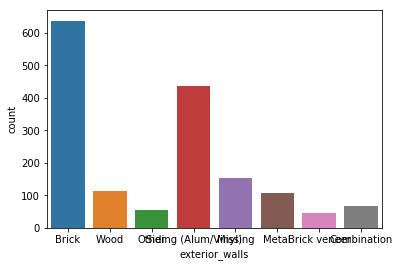

In [13]:
# Bar plot for exterior_walls
sns.countplot('exterior_walls', data=df)

As with the <code style="color:steelblue">'exterior_walls'</code> feature above, for <code style="color:steelblue">'roof'</code>I can start by showing the bar plot and grouping classes that are quite similar. Then I'll create a generic <code style="color:crimson">'other'</code> category to contain the remaining sparse categories. Finally, we display the bar plot again to verify the changes.

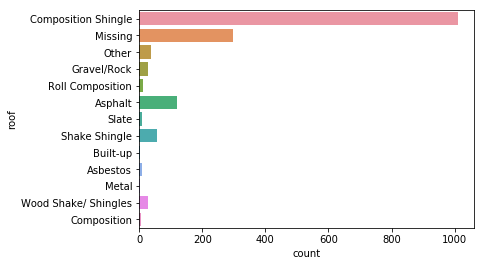

In [14]:
# Bar plot for roof
sns.countplot(y='roof', data=df)

In [15]:
# Group 'Composition' and 'Wood Shake/ Shingles' into 'Composition Shingle'
df.roof.replace(['Composition', 'Wood Shake/ Shingles'], 'Composition Shingle', inplace=True)

# List of classes to group
other_roof = ['Other', 'Gravel/Rock', 'Roll Composition', 'Slate', 'Built-up', 'Asbestos', 'Metal']

# Group other classes into 'Other'
df.roof.replace(other_roof, 'Other', inplace=True)

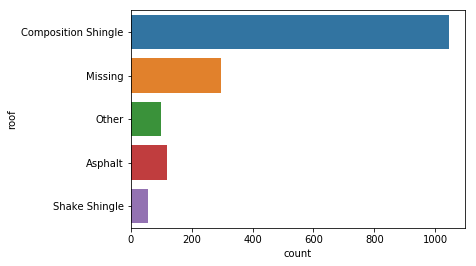

In [16]:
# Bar plot for roof
sns.countplot(y='roof', data=df)

Much nicer!
<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>



<br id="dummy">
### 4. Encode dummy variables

Python machine learning algorithms cannot handle categorical features directly. So we create dummy variables to transform them into a more usable form. Thankfully, there is a pandas function to do exactly that, <code style="color:steelblue">.get_dummies()</code>. All we have to do is pass it a list of the categorical variables.

In [17]:
# Create new dataframe with dummy features
df = pd.get_dummies(df, columns = ['roof', 'exterior_walls', 'property_type'])

# First 5 rows of dataframe
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,two_and_two,during_recession,property_age,school_score,roof_Asphalt,roof_Composition Shingle,roof_Missing,roof_Other,roof_Shake Shingle,exterior_walls_Brick,exterior_walls_Brick veneer,exterior_walls_Combination,exterior_walls_Metal,exterior_walls_Missing,exterior_walls_Other,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,property_type_Apartment / Condo / Townhouse,property_type_Single-Family
1,216500,1,1,612,1965,0,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006,0,0,41,9.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
2,279900,1,1,615,1963,0,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012,0,1,49,24.0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
3,379900,1,1,618,2000,33541,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005,0,0,5,27.0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0
4,340000,1,1,634,1992,0,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002,0,0,10,27.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
5,265000,1,1,641,1947,0,0.0,146,10,23,27,86,9,60,52,28.0,15.0,86.0,168.0,58.0,8.0,3.0,2004,0,0,57,24.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>

<br id="remove">
### 5. Remove unused or redundant features

Finally, let's remove unused for redundant features from the dataset and save the analytical base table.

In [18]:
# Drop 'tx_year' and 'year_built' from the dataset
df = df.drop(['tx_year', 'year_built'], axis=1)

In [19]:
# Save analytical base table
df.to_csv('analytical_base_table.csv', index=None)

<br>
## Next Steps
As a reminder, here are a few things we did in this module:
* Made several indicator features from domain knowledge.
* Created the interaction feature <code style="color:steelblue">'property_age'</code>.
* Grouped sparse classes in the <code style="color:steelblue">'exterior_walls'</code> and <code style="color:steelblue">'roof'</code> features.
* Encoded dummy variables and saved the final analytical base table.

In the next module, <span style="color:royalblue">Part 4: Model Training</span>, we'll walk through model training for our selection of regression algorithms.
<div style="text-align:center; margin: 40px 0 40px 0;">
[**Back to Contents**](#toc)
</div>